# Credit Card Fraud Analysis and Detection

## Introduction

Objective:
- Detect fraudulent transactions in credit card data using machine learning techniques.
- Build a model that effectively identifies fraudulent transactions while minimizing false positives.

Importance:
- Credit card fraud detection is crucial for financial security.
- Accurate detection systems can prevent significant financial losses and build trust.

### About the dataset
This project will be using the [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) dataset. It is an anonymized credit card transactions dataset with datapoints labeled as fraudulent or genuine.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data cannot be provided. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

The feature 'Time' contains the seconds elapsed between a transaction and the first transaction in the dataset. 

The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 

Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## EDA

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

RANDOM_SEED = 42

In [3]:
df_raw = pd.read_csv(r'dataset\creditcard.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

All the columns are of numeric type and have non-null count equal to the number of datapoints, hence we can for sure say that no missing values are present.

In [4]:
df_raw[['Time', 'Amount', 'Class']].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


The `Class` column alone is binary, rest of the columns except for `Time` and `Amount` are principle components obtained with PCA.

We'll have a look at the class counts.

In [5]:
print("# Valid transactions: {}\n# Fraud transactions: {}\nFraud%: {:.4f}%".format(len(df_raw[df_raw['Class']==0]), len(df_raw[df_raw['Class']==1]), len(df_raw[df_raw['Class']==1])/(len(df_raw))*100))

# Valid transactions: 284315
# Fraud transactions: 492
Fraud%: 0.1727%


As mentioned in the introduction, the dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Let's try and visualize any trends of amount and time between frauds and non-frauds.

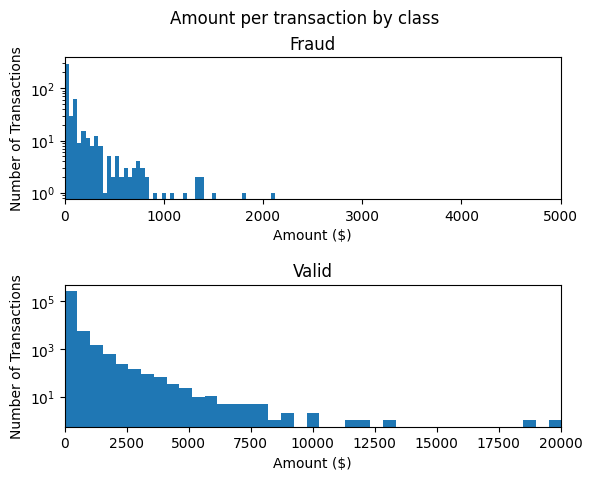

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
f.suptitle('Amount per transaction by class')
bins = 50

ax1.hist(df_raw[df_raw['Class']==1]['Amount'], bins=bins)
ax1.set_title('Fraud')
ax1.set_xlim((0, 5000))
ax1.set_xlabel('Amount ($)')
ax1.set_ylabel('Number of Transactions')
ax1.set_yscale('log')

ax2.hist(df_raw[df_raw['Class']==0]['Amount'], bins=bins)
ax2.set_title('Valid')
ax2.set_xlim((0, 20000))
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Number of Transactions') 
ax2.set_yscale('log')

plt.subplots_adjust(hspace=0.6)
plt.show();

The fraud amounts are small and the trend are similar between fraud and non-fraud. We can perform log tranformation to reduce the skewness and make the distribution more normal.

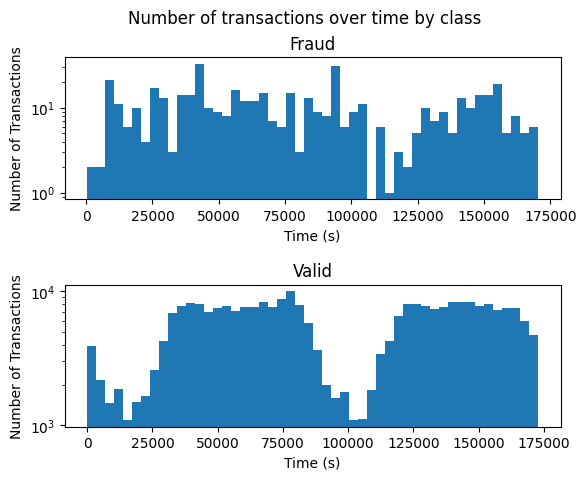

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
f.suptitle('Number of transactions over time by class')
bins = 50

ax1.hist(df_raw[df_raw['Class']==1]['Time'], bins=bins)
ax1.set_title('Fraud')
# ax1.set_xlim((0, 5000))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Number of Transactions')
ax1.set_yscale('log')

ax2.hist(df_raw[df_raw['Class']==0]['Time'], bins=bins)
ax2.set_title('Valid')
# ax2.set_xlim((0, 20000))
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Number of Transactions') 
ax2.set_yscale('log')

plt.subplots_adjust(hspace=0.6)
plt.show();

There doesn't seem to be much of a trend between fraud and valid transactions, the valid transactions are spread evenly over certain time periods but the fraud transactions are not that evenly distributed and is random.

But we can observe that the peaks of fraudulent transactions are at the beginning and the end of what I assume is day-time.

## Pre-processing

### Handling Outliers
We shall plot box plots for each variable/column/feature for basic visualization.

In [7]:
features = list(df_raw.iloc[:,1:-1].columns)
print(f"Selected Features: {features}")

Selected Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


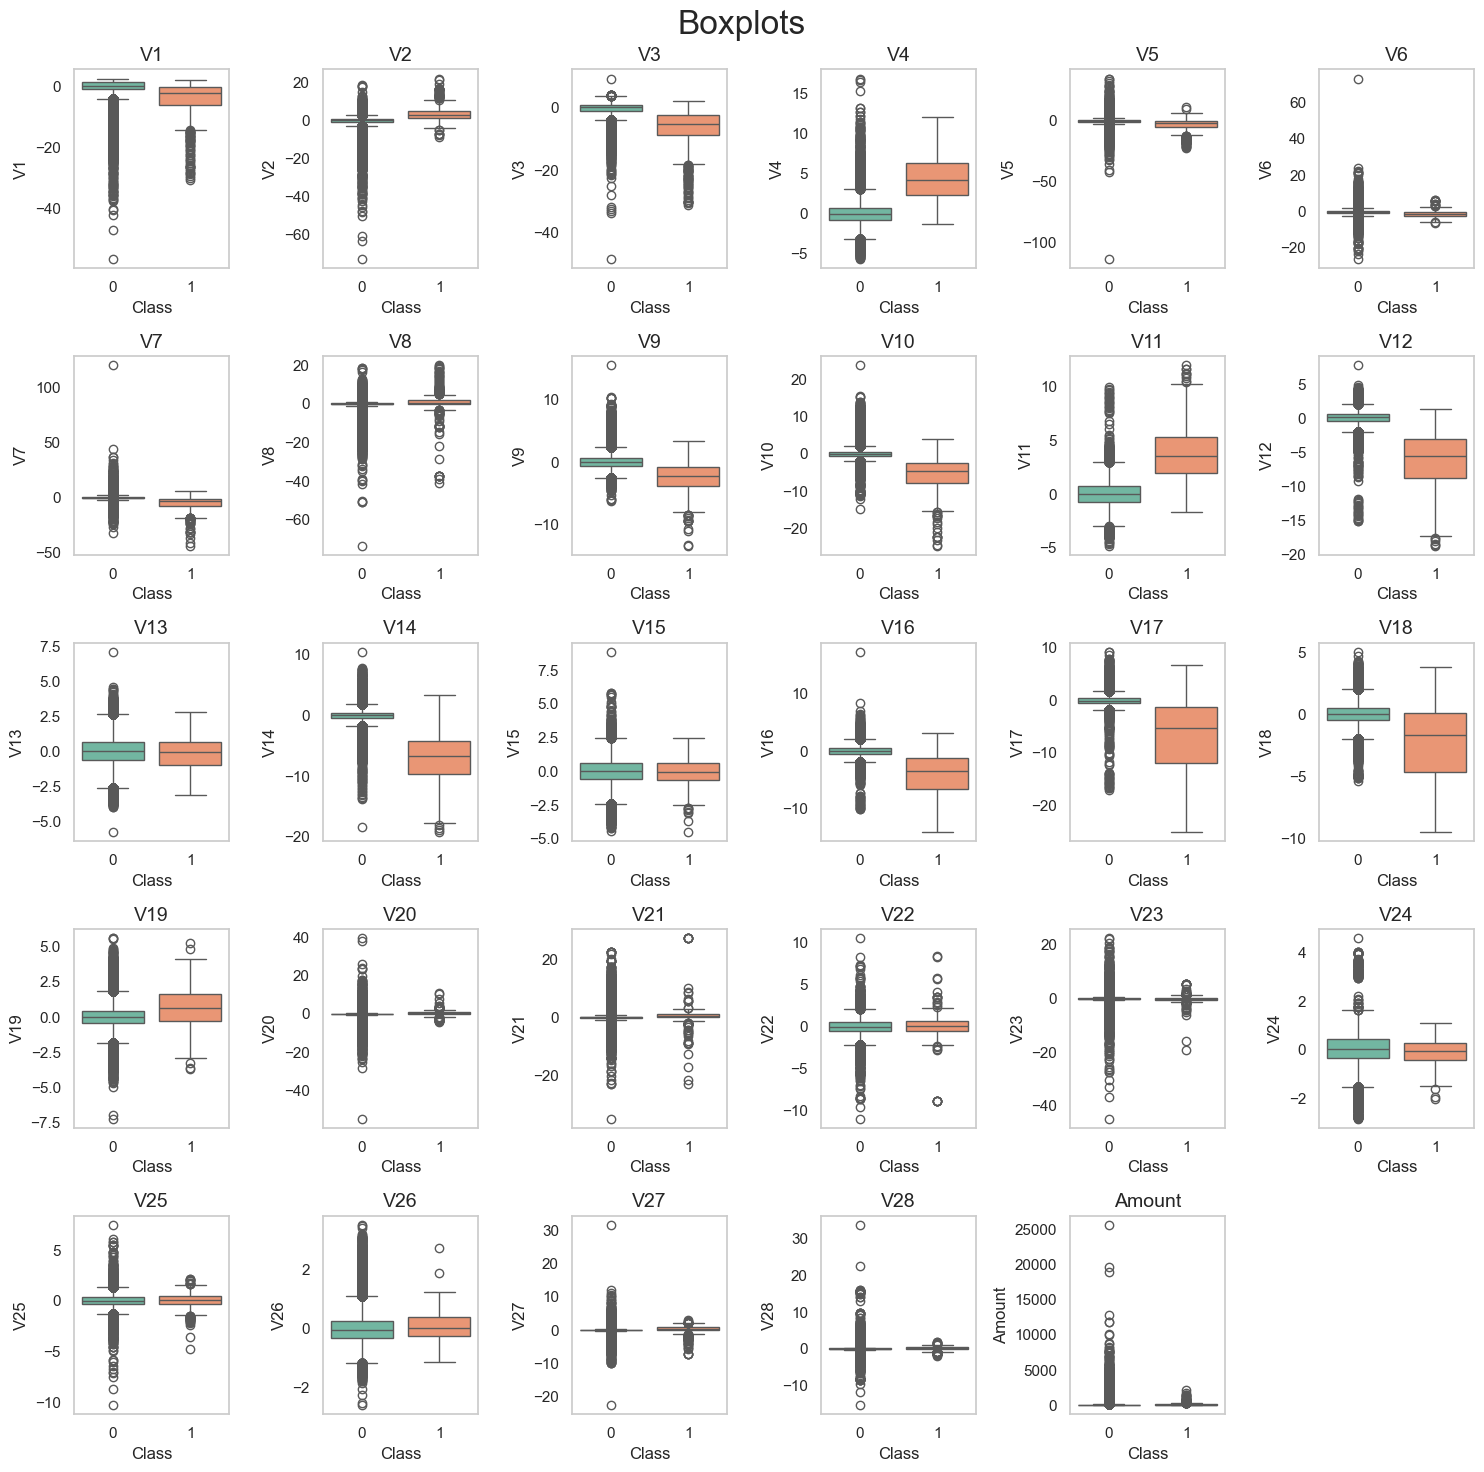

In [8]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(5, 6, figsize=(15, 15), sharex=False, sharey=False)
axes = axes.flatten()  

for i, feature in enumerate(features):
    sns.boxplot(data=df_raw, ax=axes[i], x='Class', y=feature, 
                hue='Class', palette='Set2', legend=False)
    axes[i].set_title(feature, fontsize=14)
    axes[i].grid(False)

for j in range(29, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots", size=24)
plt.tight_layout()
plt.show()

Looking at the Boxplots, there seem to be a lot of outliers in every feature.

For a machine learning model to perform the best, the data to a large extent must be distributed normally. To do that we must remove the outliers.

But before that we'll first have a look whether the fraud datapoint itself is an outlier or not. For that we can use some popular techniques to mark the outliers like,
1. Z-Score
2. IQR (Interquartile Range)
3. LOF (Local Outlier Factor)
4. Isolation Forest
5. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

We shall import the outlier detection functions from the `detect_outliers.py` file.

In [9]:
import detect_outliers as do

In [10]:
outlier_indices = do.detect_outliers_z_score(df_raw, features)
df_raw.iloc[outlier_indices]['Class'].value_counts()

Total Outliers: 37816


Class
0    37372
1      444
Name: count, dtype: int64

In [11]:
outlier_indices = do.detect_outliers_iqr(df_raw, features)
df_raw.iloc[outlier_indices]['Class'].value_counts()

Total Outliers: 138473


Class
0    137996
1       477
Name: count, dtype: int64

In [12]:
outlier_indices = do.detect_outliers_isolation_forest(df_raw, features)
df_raw.iloc[outlier_indices]['Class'].value_counts()

Total Outliers: 11372


Class
0    10962
1      410
Name: count, dtype: int64

In [13]:
outlier_indices = do.detect_outliers_lof(df_raw, features)
df_raw.iloc[outlier_indices]['Class'].value_counts()

Total Outliers: 12313


Class
0    12146
1      167
Name: count, dtype: int64

In [14]:
outlier_indices = do.detect_outliers_dbscan(df_raw, features)
df_raw.iloc[outlier_indices]['Class'].value_counts()

Total Outliers: 81560


Class
0    81108
1      452
Name: count, dtype: int64

We can see that each technique is picking the majority of the frauds (class 1) as outliers, this is an indication that the features in your dataset contain useful information for detecting fraud, as fraud cases are statistically different from regular transactions. 

But a proportionately larger number of valid transactions (class 0) is also being marked as an outlier. These might be high-value transactions or rare patterns that are statistically different from the norm but are not fraudulent.

Removing fraud outliers will be a loss of information and will affect the performance of the model.

When it comes to dropping valid outliers, we have two options:
1. Keep the Outliers: Since outliers could still represent legitimate non-fraudulent behavior, keeping them in the dataset might help detect edge cases that resemble fraud. However, this may increase the complexity of the model.
2. Remove the Outliers: If the outliers in Class 0 are noisy or irrelevant, consider removing them. This might simplify the dataset, making it easier for the model to focus on detecting fraudulent cases but may miss out on valuable information and unique patterns of possible valid transactions. 

Hence we shall not drop any outliers and train the models with them included.

### Feature selection

To ensure that the features used in the model are relevant for distinguishing fraud from non-fraud cases. If there are highly correlated features or features with low predictive power, consider removing them.

This can be done by dropping features that have correlation coefficient of more than 0.8. And the we go ahead and find features that have high predictive power using the give code to do feature selection using SelectKBest from sci-kit learn.

This will help up use reduce the complexity of the models.

In [8]:
df_transformed = df_raw.copy()

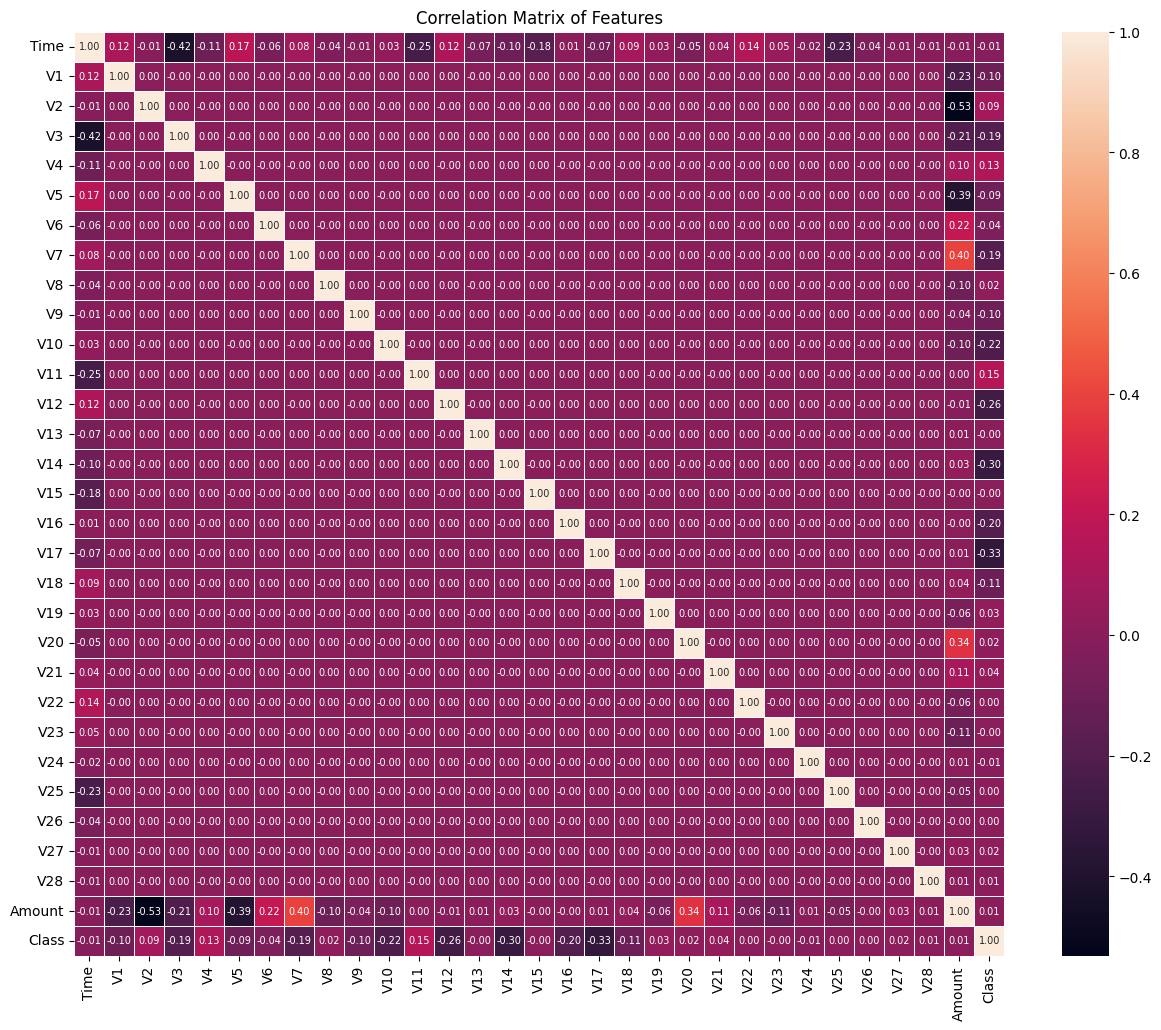

In [9]:
df_corr = df_transformed.corr()
plt.figure(figsize=(15,12))
sns.heatmap(df_corr, annot=True, fmt='.2f', linewidths=0.5, annot_kws={"size":7})
plt.title('Correlation Matrix of Features')
plt.show()

In [10]:
flg = False
for i in range(len(df_corr.columns)):
    for j in range(len(df_corr.columns)):
        if df_corr.iloc[i, j] > 0.8 and i != j:
            print(f"{df_corr.columns[i]} and {df_corr.columns[j]}: {df_corr.iloc[i, j]}")
            flg = True
if not flg:
    print("None")

None


There seems to be no pair of features that are strongly correlated, so we will not be dropping any features in this regard. We'll now select the top 15 features that have highest predictive power.

In [11]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split

In [12]:
X = df_transformed.drop('Class', axis=1)
y = df_transformed['Class']

# Train and test splits are made to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [13]:
selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

feature_scores = selector.scores_

print("Selected Top K Features (indices):", selector.get_support(indices=True))

selected_features = X_train.columns[selector.get_support()]
feature_scores_df_transformed = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': feature_scores
}).sort_values(by='Score', ascending=False)

print("\nFeature Scores DataFrame:")
print(feature_scores_df_transformed)

Selected Top K Features (indices): [ 2  3  4  5  7  9 10 11 12 14 16 17 18 21 27]

Feature Scores DataFrame:
   Feature     Score
14     V14  0.008136
17     V17  0.008008
12     V12  0.007588
10     V10  0.007549
11     V11  0.006904
16     V16  0.006074
4       V4  0.005110
3       V3  0.004856
9       V9  0.004334
18     V18  0.004154
7       V7  0.003996
2       V2  0.003150
21     V21  0.002368
5       V5  0.002353
27     V27  0.002247
6       V6  0.002205
1       V1  0.002030
0     Time  0.002003
8       V8  0.001832
28     V28  0.001665
19     V19  0.001469
29  Amount  0.001340
20     V20  0.001003
23     V23  0.000808
24     V24  0.000550
25     V25  0.000443
26     V26  0.000442
13     V13  0.000326
22     V22  0.000289
15     V15  0.000207


We can use the above selected features in our model. We will first train the model on the complete dataset and then train the model on the selected features.

### Feature Scaling

This step will help the models tain better.

In [14]:
df_transformed.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The data of many features look normally distributed. Apart from the principle components that are already scaled, we shall scale the Amount and Time features as well. This is benefitial especially if you plan to use models sensitive to feature scaling.

But before scaling we must always split the data so that data leakage doesn't affect our results. The split has already been performed in the feature selection step, so we can proceed with the scaling step.

In [15]:
scaler = StandardScaler()
df_transformed = df_raw.drop_duplicates().reset_index(drop=True)
df_transformed['Amount'] = scaler.fit_transform(df_transformed[['Amount']])
df_transformed['Time'] = scaler.fit_transform(df_transformed[['Time']])

In [16]:
df_transformed[['Amount', 'Time']].describe()

,Amount,Time
count,2.837260e+05,2.837260e+05
mean,-5.409347e-17,1.218105e-16
std,1.000002e+00,1.000002e+00
min,-3.533268e-01,-1.996823e+00
25%,-3.309625e-01,-8.552128e-01
50%,-2.654671e-01,-2.131081e-01
75%,-4.378088e-02,9.369423e-01
max,1.022476e+02,1.642362e+00


### Handling Imbalaced classes

There are two approaches to making the data balanced,
1. Undersampling
2. Oversampling

#### Undersampling
We will try undersampling (random) valid transactions from the imblearn library.

In [27]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

print("X_train_undersampled shape:", X_train_undersampled.shape)
print("y_train_undersampled distribution:", pd.Series(y_train_undersampled).value_counts())


X_train_undersampled shape: (788, 30)
y_train_undersampled distribution: Class
0    394
1    394
Name: count, dtype: int64


#### Oversampling
From imbalance-learn API, we will be using the over_sampling.ADASYN class.

This method is similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled.

In [20]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=RANDOM_SEED, n_neighbors=3)
X_train_oversampled,y_train_oversampled=adasyn.fit_resample(X_train,y_train)

We must test with the original test split and shouldn't oversample the test data.

In [21]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_oversampled)))

Original dataset shape Counter({0: 227451, 1: 394})
Resampled dataset shape Counter({1: 227519, 0: 227451})


## Model selection and training

We will now perform training and testing of models to predict the class of a datapoint as accurately as possible.

We can make use of `logistic regression` but it is susceptible poor performance on imbalanced datasets. We can expect better results with `decision tree classifier` and `random forest` on imbalanced data as well with random forest potentially showing better results due to ensemble effect.

We shall try training the three models on both imbalanced and balanced data, and the balanced data can be obtained through oversampling or undersampling using `SMOTE` and `ADASYN`.

We will have to keep an eye on evaluation metrics. Since the dataset is imbalanced, avoid using accuracy as the main metric. We'll focus on:
1. Precision: To reduce false positives.
2. Recall: To catch as many fraud cases as possible.
3. F1-Score: A balanced measure of precision and recall (harmonic mean of precision and recall).
4. AUC-ROC Curve: Evaluate model performance in distinguishing between classes.

### Model building

Since we'll be training the models multiple time, let's code a helper function to train and evaluate the models.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [23]:
def train_model(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates multiple classifiers on the given training and test datasets.

    This function takes training and test feature sets and labels, trains three different classifiers
    (Logistic Regression, Decision Tree Classifier, and RandomForestClassifier) on the training data, 
    and evaluates their performance on the test data. For each classifier, it prints the confusion matrix, 
    classification report, ROC-AUC score, and plots the ROC curve.

    Parameters:
    X_train (pd.DataFrame or np.ndarray): Features of the training data.
    X_test (pd.DataFrame or np.ndarray): Features of the test data.
    y_train (pd.Series or np.ndarray): Labels of the training data.
    y_test (pd.Series or np.ndarray): Labels of the test data.

    Returns:
    None: This function does not return any values but prints evaluation metrics and plots.

    Notes:
    - The function assumes that the test data includes both positive and negative class samples.
    - ROC-AUC scores and ROC curves are only meaningful if the classifier provides probability estimates 
      for the positive class.
    - This function will display the ROC curves in separate plots for each classifier.
    """
    
    classifier = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree Classifier": DecisionTreeClassifier(),
        "RandomForestClassifier": RandomForestClassifier(random_state=RANDOM_SEED)
    }

    for name, model in classifier.items():
        print(f"\n================ {name} ================\n")
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{conf_matrix}\n")

        # Accuracy
        print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}\n")
        
        # Classification report
        clf_report = classification_report(y_test, y_pred)
        print(f"\nClassification Report:\n{clf_report}\n")
    
        # ROC-AUC Score
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"ROC-AUC Score (Imbalanced Data): {roc_auc}\n")
    
        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve\nusing {name}', fontsize=10)
        plt.legend(loc='best')
        plt.show()
        print("\n")

### Training on imbalanced data


================ Logistic Regression ================

Confusion Matrix:
[[56829    35]
 [   43    55]]


Accuracy: 0.9986306660580738


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.56      0.59        98

    accuracy                           1.00     56962
   macro avg       0.81      0.78      0.79     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.7803044930690339



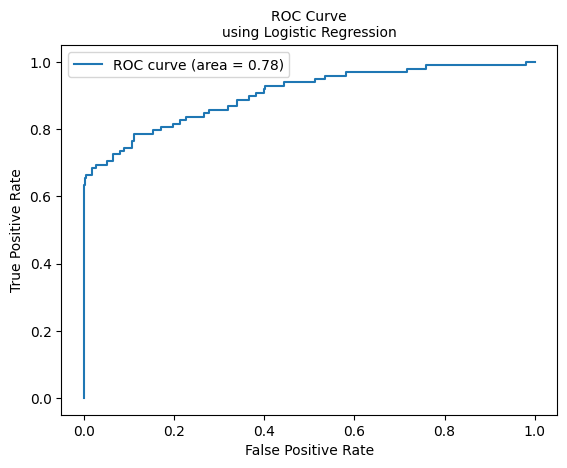




================ Decision Tree Classifier ================

Confusion Matrix:
[[56831    33]
 [   22    76]]


Accuracy: 0.9990344440153085


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.78      0.73        98

    accuracy                           1.00     56962
   macro avg       0.85      0.89      0.87     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8874649360306869



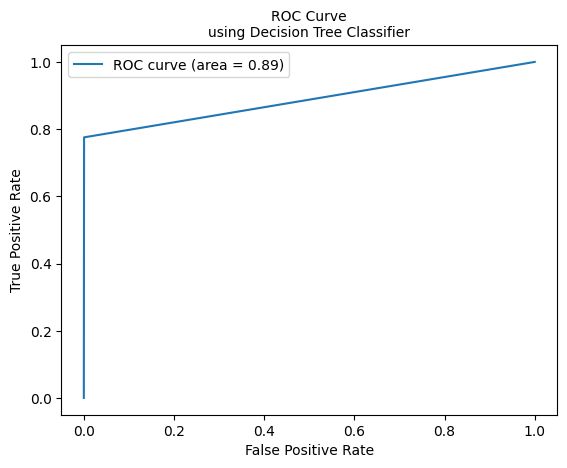




================ RandomForestClassifier ================

Confusion Matrix:
[[56862     2]
 [   23    75]]


Accuracy: 0.9995611109160493


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8826354754056941



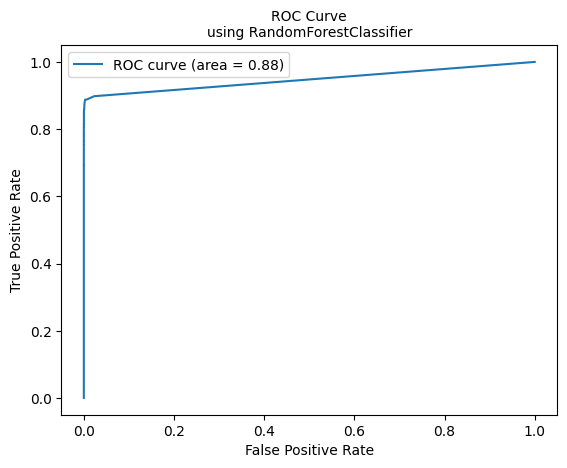

In [24]:
train_model(X_train, X_test, y_train, y_test)

### Training on balanced data

#### Undersampled data


================ Logistic Regression ================

Confusion Matrix:
[[53510  3354]
 [    7    91]]


Accuracy: 0.9409957515536673


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.93      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962


ROC-AUC Score (Imbalanced Data): 0.9347942961652866



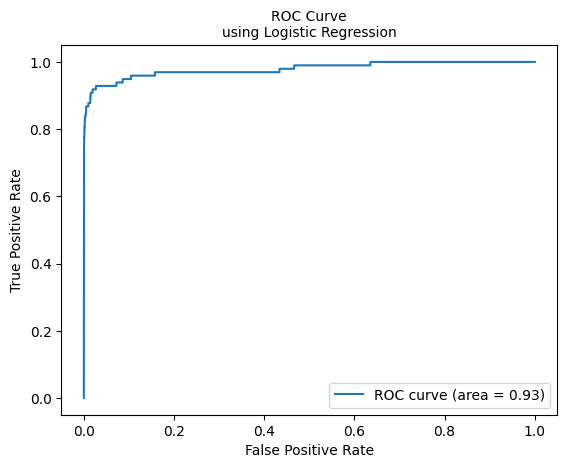




================ Decision Tree Classifier ================

Confusion Matrix:
[[50243  6621]
 [    7    91]]


Accuracy: 0.8836417260629894


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56864
           1       0.01      0.93      0.03        98

    accuracy                           0.88     56962
   macro avg       0.51      0.91      0.48     56962
weighted avg       1.00      0.88      0.94     56962


ROC-AUC Score (Imbalanced Data): 0.906067861162473



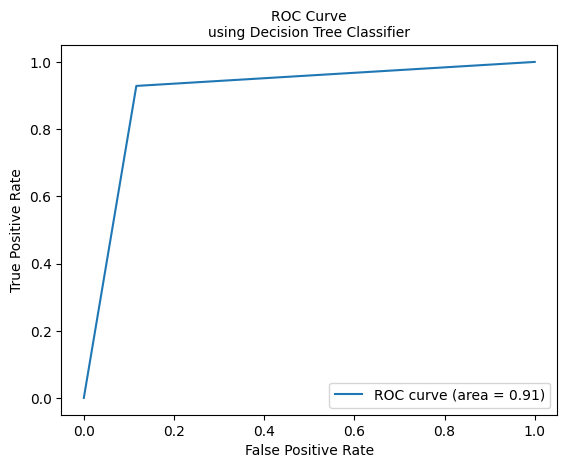




================ RandomForestClassifier ================

Confusion Matrix:
[[55513  1351]
 [    6    92]]


Accuracy: 0.9761771005231558


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.94      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.98      0.99     56962


ROC-AUC Score (Imbalanced Data): 0.9575085345055299



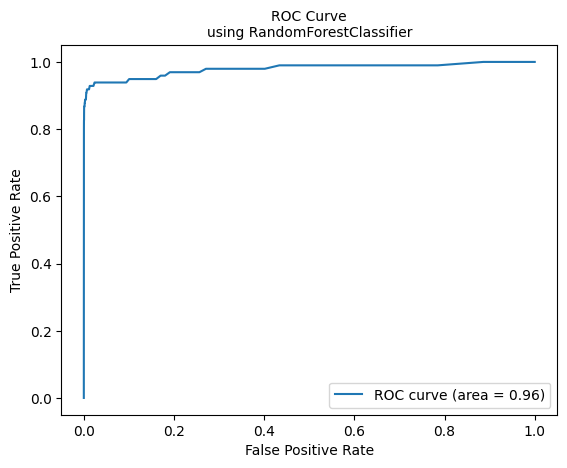

In [28]:
train_model(X_train_undersampled, X_test, y_train_undersampled, y_test)

#### Oversampled data


================ Logistic Regression ================

Confusion Matrix:
[[55662  1202]
 [   11    87]]


Accuracy: 0.9787051016467119


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.89      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962


ROC-AUC Score (Imbalanced Data): 0.9333084739241785



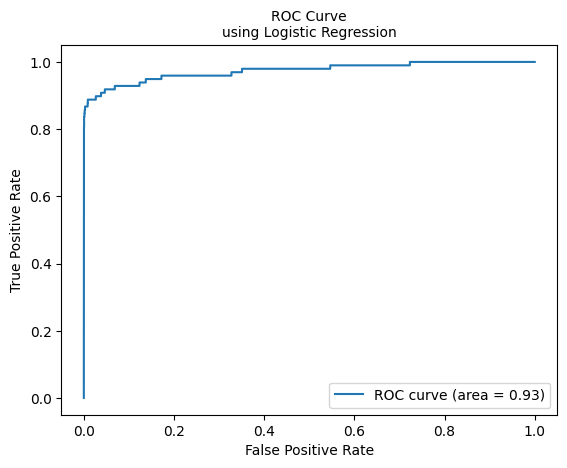




================ Decision Tree Classifier ================

Confusion Matrix:
[[56798    66]
 [   25    73]]


Accuracy: 0.9984024437344194


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.74      0.62        98

    accuracy                           1.00     56962
   macro avg       0.76      0.87      0.81     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8718686475715779



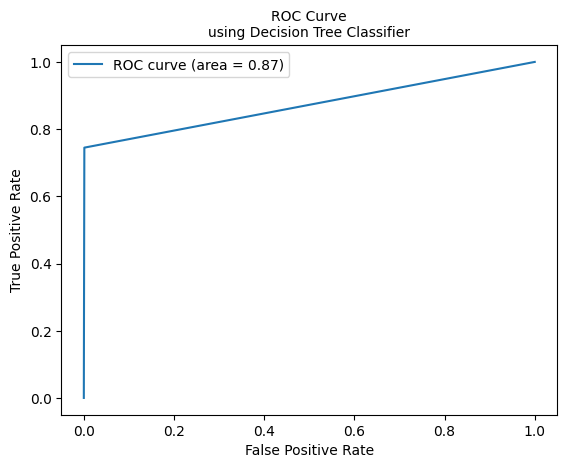




================ RandomForestClassifier ================

Confusion Matrix:
[[56854    10]
 [   15    83]]


Accuracy: 0.9995611109160493


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.9233814586611235



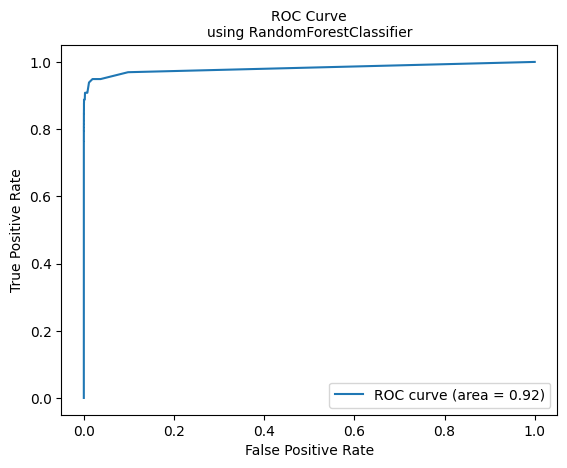

In [26]:
train_model(X_train_oversampled, X_test, y_train_oversampled, y_test)

### Training on dataset with selected features

#### Training on Imbalanced data


================ Logistic Regression ================

Confusion Matrix:
[[56855     9]
 [   43    55]]


Accuracy: 0.9990871107053826


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.56      0.68        98

    accuracy                           1.00     56962
   macro avg       0.93      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.7805331087133783



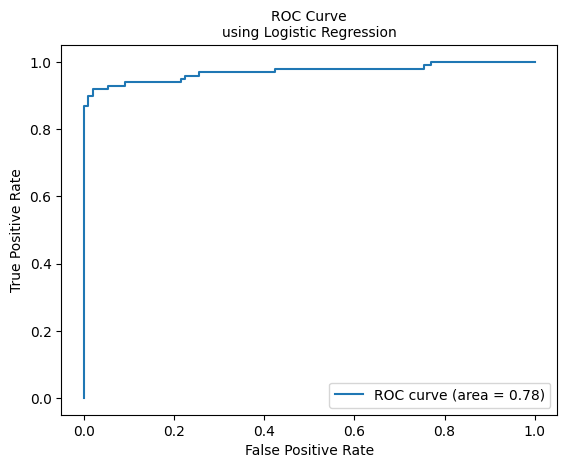




================ Decision Tree Classifier ================

Confusion Matrix:
[[56843    21]
 [   26    72]]


Accuracy: 0.9991748885221726


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.73      0.75        98

    accuracy                           1.00     56962
   macro avg       0.89      0.87      0.88     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8671622876781551



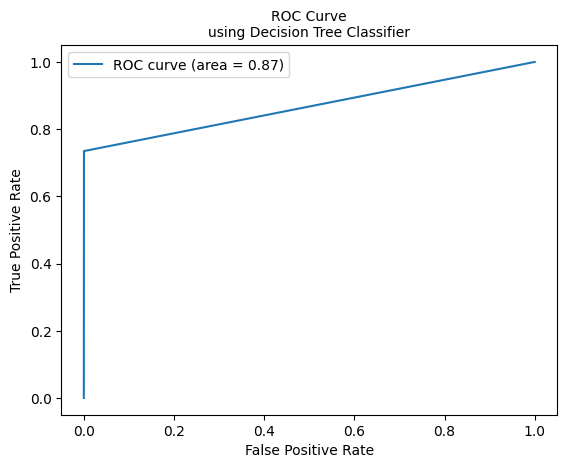




================ RandomForestClassifier ================

Confusion Matrix:
[[56863     1]
 [   22    76]]


Accuracy: 0.9995962220427653


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.78      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8877463091314184



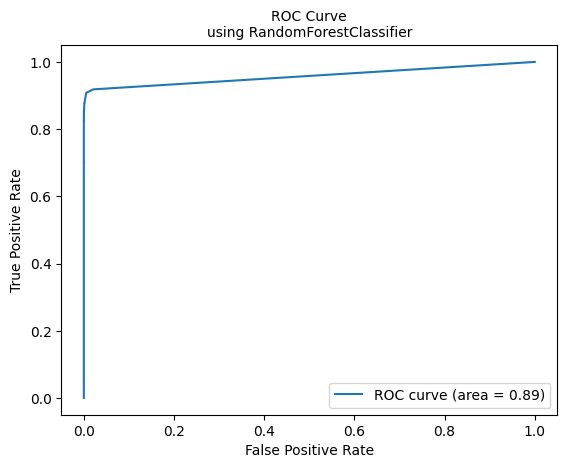

In [29]:
train_model(X_train_selected, X_test_selected, y_train, y_test)

#### Training on balanced data

##### Undersampled

In [30]:
X_train_selected_undersampled, y_train_selected_undersampled = undersampler.fit_resample(X_train_selected, y_train)

print("X_train_undersampled shape:", X_train_selected_undersampled.shape)
print("y_train_undersampled distribution:", pd.Series(y_train_selected_undersampled).value_counts())

X_train_undersampled shape: (788, 15)
y_train_undersampled distribution: Class
0    394
1    394
Name: count, dtype: int64



================ Logistic Regression ================

Confusion Matrix:
[[55406  1458]
 [   10    88]]


Accuracy: 0.9742284329904146


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.90      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962


ROC-AUC Score (Imbalanced Data): 0.9361595299346526



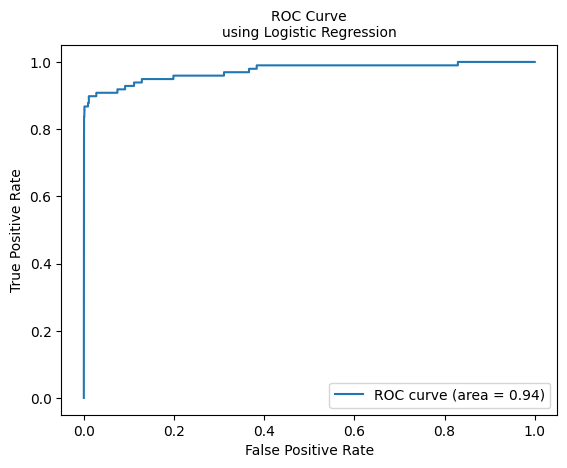




================ Decision Tree Classifier ================

Confusion Matrix:
[[52210  4654]
 [    5    93]]


Accuracy: 0.9182086303149468


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.95      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.93      0.50     56962
weighted avg       1.00      0.92      0.96     56962


ROC-AUC Score (Imbalanced Data): 0.9335675955807197



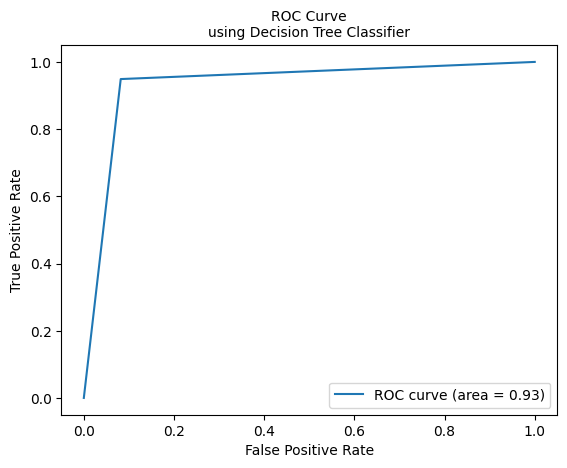




================ RandomForestClassifier ================

Confusion Matrix:
[[55269  1595]
 [    7    91]]


Accuracy: 0.9718759875004389


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


ROC-AUC Score (Imbalanced Data): 0.9502610237961251



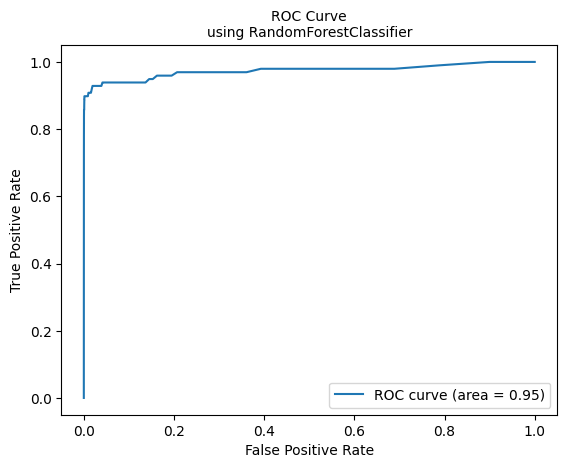

In [31]:
train_model(X_train_selected_undersampled, X_test_selected, y_train_selected_undersampled, y_test)

##### Oversampled

In [32]:
X_train_selected_oversampled,y_train_selected_oversampled=adyn.fit_resample(X_train_selected,y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_selected_oversampled)))

Original dataset shape Counter({0: 227451, 1: 394})
Resampled dataset shape Counter({0: 227451, 1: 227430})



================ Logistic Regression ================

Confusion Matrix:
[[50478  6386]
 [    7    91]]


Accuracy: 0.887767283452126


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56864
           1       0.01      0.93      0.03        98

    accuracy                           0.89     56962
   macro avg       0.51      0.91      0.48     56962
weighted avg       1.00      0.89      0.94     56962


ROC-AUC Score (Imbalanced Data): 0.9081341948709704



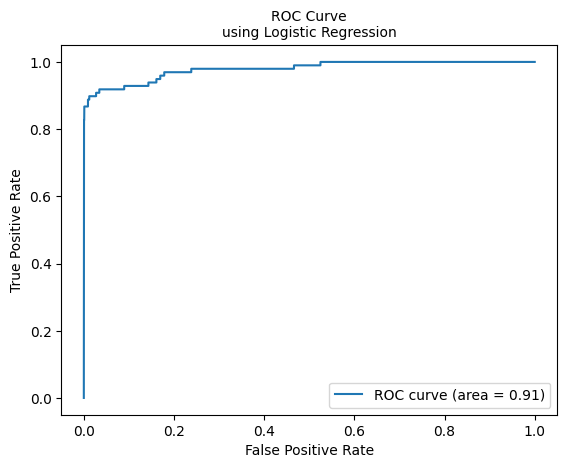




================ Decision Tree Classifier ================

Confusion Matrix:
[[56800    64]
 [   20    78]]


Accuracy: 0.9985253326779256


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.55      0.80      0.65        98

    accuracy                           1.00     56962
   macro avg       0.77      0.90      0.82     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8973964374720063



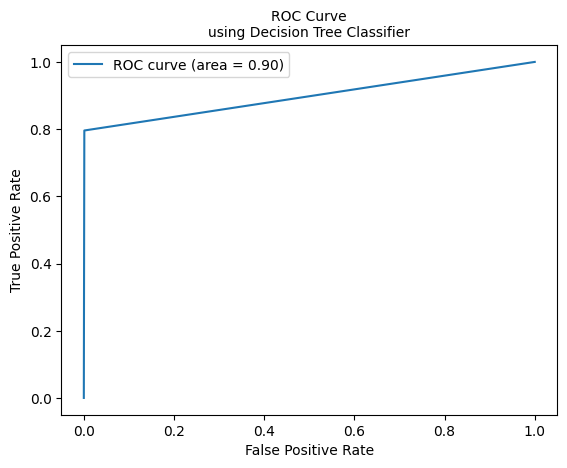




================ RandomForestClassifier ================

Confusion Matrix:
[[56851    13]
 [   16    82]]


Accuracy: 0.9994908886626171


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.9182530391166033



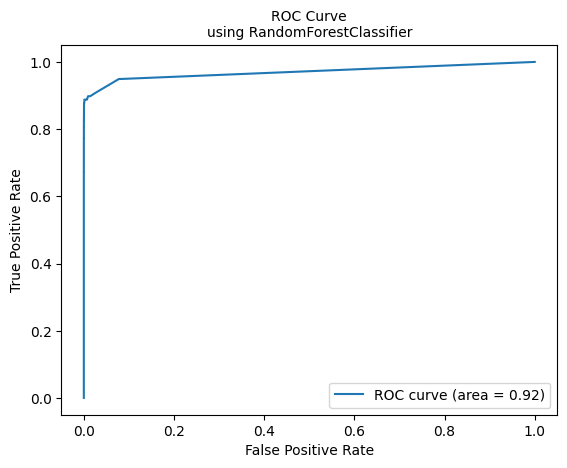

In [34]:
train_model(X_train_selected_oversampled, X_test_selected, y_train_selected_oversampled, y_test)

### Summary on performance
This performance analysis compares different classifiers (Logistic Regression, Decision Tree, and Random Forest) on an imbalanced dataset, as well as on undersampled and oversampled versions of the balanced dataset. Feature selection was also considered, giving a comprehensive view of the model's effectiveness across various data treatments.

1. Imbalanced Data
    - Logistic Regression: Good for class 0, poor for class 1 with an F1-score of **0.59** and ROC-AUC of **0.78**.
    - Decision Tree: Improved performance for class 1 with F1-score of **0.73** and ROC-AUC of **0.89**, but class 0 suffers with recall of **0.7**.
    - Random Forest: Best results among imbalanced models for class 1 with F1-score of **0.86** and ROC-AUC of **0.88**, but overfitting is a concern with perfect precision for class 0.

2. Balanced Data (Undersampled)
    - Logistic Regression: Drastic drop in class 1 precision of **0.03** while recall is a high **0.93**, indicating poor precision-recall balance.
    - Decision Tree: Extremely low precision for class 1 of **0.01** and a low F1-score of **0.03**, showing inefficiency in undersampled data.
    - Random Forest: Slightly better than Logistic and Decision Trees with an F1-score of **0.12** for class 1 but still not sufficient for generalization.

3. Balanced Data (Oversampled)
    - Logistic Regression: Marginal improvement in class 1 F1-score of **0.13**, with a decent ROC-AUC of **0.93**.
    - Decision Tree: Significant improvement in class 1 precision of **0.53** and F1-score of **0.62**, though still not optimal.
    - Random Forest: Best performing model for class 1 in oversampled data with a precision of **0.89** and an F1-score of **0.87**, with an overall ROC-AUC of **0.92**.

4. Imbalanced Data with Feature Selection
    - Logistic Regression: Improvement in class 1 F1-score of **0.68** and ROC-AUC of **0.78**, compared to the original imbalanced data.
    - Decision Tree: Strong performance with an F1-score of **0.75** and a ROC-AUC of **0.87**, close to Random Forest.
    - Random Forest: Continued to perform strongly with an F1-score of **0.87** for class 1 and a ROC-AUC of **0.89**.

5. Balanced Data with Feature Selection (Undersampled)
    - Logistic Regression: Class 1 performance remained low with an F1-score of **0.11**, despite high recall of **0.90**.
    - Decision Tree: Minimal improvement with an F1-score of **0.04** for class 1.
    - Random Forest: Improved over Logistic and Decision Trees with an F1-score of **0.10** for class 1, but still weak overall.

6. Balanced Data with Feature Selection (Oversampled)
    - Logistic Regression: Poor performance for class 1 with an F1-score of **0.03**, indicating feature selection and oversampling didn't improve this model.
    - Decision Tree: Noticeable boost in class 1 precision of **0.55** and F1-score of **0.65**, with a ROC-AUC of **0.90**.
    - Random Forest: Consistent performance with class 1 F1-score of **0.85** and a solid ROC-AUC of **0.92**.


### Key Insights & Recommendations
1. Imbalanced Data: Random Forest consistently performs the best, especially for class 1, with strong F1-scores and ROC-AUC values. However, imbalanced data shows clear overfitting for class 0 across models.
2. Balanced (Undersampled) Data: Undersampling significantly reduced the performance across all models, particularly on class 1 precision and F1-scores, with Logistic Regression and Decision Tree performing poorly.
3. Balanced (Oversampled) Data: Random Forest continues to perform best, especially with oversampled data and feature selection. It provides the most balanced trade-off between precision and recall for class 1, with the highest F1-scores and ROC-AUC.
4. Feature Selection: Feature selection had a positive impact on Decision Trees and Random Forest models, improving their performance on class 1 in both imbalanced and oversampled datasets.

### Recommendation
For **class-imbalanced datasets**, Random Forest with **oversampling** and **feature selection** provides the most effective balance between precision and recall, achieving high performance for both classes. For business applications, especially banking, where false negatives are critical (fraud detection, etc.), this approach should be prioritized.

## Conclusion and future work

In this analysis, we performed a comprehensive exploration and modeling process for credit card fraud detection using an imbalanced and PCA-ed dataset through the following steps:

1. Data Exploration and Preprocessing: We began by loading and exploring the dataset and performing necessary preprocessing steps.

2. Correlation Analysis: By investigating the correlations between features and mutual information, we tried to identify potential redundancies and understanding feature relationships and predictive power.

3. Handling Imbalanced Data: We applied techniques such as undersampling and oversampling to address the class imbalance. This was crucial in ensuring that our models could better learn from the minority class.

4. Model Training and Evaluation: We trained and evaluated various classifiers, including Logistic Regression, Decision Tree, and RandomForest. We assessed model performance using metrics such as confusion matrices, classification reports, ROC-AUC scores, and ROC curves.

Key Findings:

- Feature Correlations: Our correlation analysis revealed important relationships between features. This understanding can guide feature selection and engineering in future analyses.

- Model Performance: The RandomForestClassifier demonstrated best performance in detecting fraud, showing that it is a strong candidate for deployment. The ROC-AUC scores and ROC curves provided insights into each model’s performance, particularly in distinguishing between fraudulent and non-fraudulent transactions.

- Impact of Imbalance Handling: Techniques for balancing the dataset were essential in improving model performance and ensuring that the minority class (fraudulent transactions) was adequately represented in the training process.

Overall, this analysis has provided a robust framework for credit card fraud detection. The insights gained from feature correlations and model evaluations will be instrumental in refining our approach and improving detection capabilities. 

Future work could involve fine-tuning models further, k-fold validation, experimenting with additional features, and exploring other advanced techniques for handling imbalanced data.